# Video Dataset Transformation  

Transforming our dataset can help us make the most out of a limited dataset. Especially for video data that is often difficult to get in the first place, using transformations can really help reduce the total amount of video footage that is needed.

In this notebook, we show examples of what different transformations look like, to help decide what transformations to use during training.

### Initialization
Import all the functions we need.

In [2]:
import sys
sys.path.append("../../")

import os
import time
import decord
import matplotlib.pyplot as plt
import numpy as np
import warnings

import shutil
from sklearn.metrics import accuracy_score
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import urllib.request

from utils_cv.action_recognition.dataset import VideoDataset, DEFAULT_MEAN, DEFAULT_STD
from utils_cv.action_recognition.references.functional_video import denormalize
from utils_cv.action_recognition.references.transforms_video import (
    CenterCropVideo,    
    NormalizeVideo,
    RandomCropVideo,
    RandomHorizontalFlipVideo,
    RandomResizedCropVideo,
    ResizeVideo,
    ToTensorVideo,
)
from utils_cv.common.gpu import system_info
from utils_cv.common.data import data_path

system_info()
warnings.filterwarnings('ignore')

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0] 

PyTorch 1.2.0 

Torch-vision 0.4.0a0 

Available devices:
0: Tesla K80


In [3]:
%load_ext autoreload
%autoreload 2

Set parameters for this notebook:

In [4]:
VIDEO_PATH = os.path.join(str(data_path()), "drinking.mp4")

In this notebook, we'll be showing various transformations, so here's a simple helper function to easily display clips from a video.

In [5]:
def show_clip(clip, size_factor=600):
    """ Show frames in a clip """
    if isinstance(clip, torch.Tensor):
        # Convert [C, T, H, W] tensor to [T, H, W, C] numpy array
        clip = np.moveaxis(clip.numpy(), 0, -1)

    figsize = np.array([clip[0].shape[1] * len(clip), clip[0].shape[0]]) / size_factor
    fig, axs = plt.subplots(1, len(clip), figsize=figsize)
    for i, f in enumerate(clip):
        axs[i].axis("off")
        axs[i].imshow(f)

# Prepare a Sample Video
For this notebook, we'll use a sample video that we've stored in Azure blob to demonstrate the various kinds of transformations. The video is saved to this location:

In [6]:
url = (
    "https://cvbp-secondary.z19.web.core.windows.net/datasets/action_recognition/drinking.mp4"
)

Download the file from `url` and save it locally under VIDEO_PATH:

In [7]:
with urllib.request.urlopen(url) as response, open(VIDEO_PATH, "wb") as out_file:
    shutil.copyfileobj(response, out_file)

We'll use `decord` to see how many frames the video has.

In [8]:
video_reader = decord.VideoReader(VIDEO_PATH)
video_length = len(video_reader)
print("Video length = {} frames".format(video_length))

Video length = 152 frames


For the rest of the notebook, we'll use the first, middle, and last frames to visualize what the video transformations look like.

In [9]:
clip = [
    video_reader[0].asnumpy(),
    video_reader[video_length//2].asnumpy(),
    video_reader[video_length-1].asnumpy(),
]

Here's what the first, middle and last frame looks like without transformations:

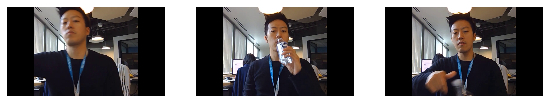

In [10]:
show_clip(clip)

Finally, we'll create a `t_clip` tensor that contains each of these three frames so that we can apply our transformations to all of them at once. 

In [11]:
# [T, H, W, C] numpy array to [C, T, H, W] tensor
t_clip = ToTensorVideo()(torch.from_numpy(np.array(clip)))
t_clip.shape

torch.Size([3, 3, 1080, 1920])

# Video Transformations

This section of the notebook shows a variety of different transformations you can apply when training your own model.

1. Resizing with the original ratio

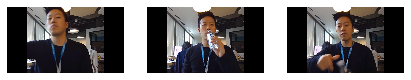

In [12]:
show_clip(ResizeVideo(size=800)(t_clip))

2. Resizing

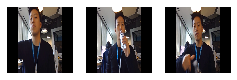

In [13]:
show_clip(ResizeVideo(size=800, keep_ratio=False)(t_clip))

3. Center cropping

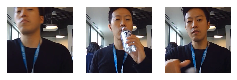

In [14]:
show_clip(CenterCropVideo(size=800)(t_clip))

4. Random cropping

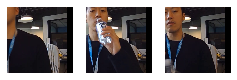

In [15]:
random_crop = RandomCropVideo(size=800)
show_clip(random_crop(t_clip))

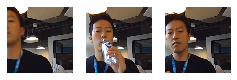

In [16]:
show_clip(random_crop(t_clip))

5. Randomly resized cropping

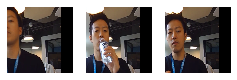

In [17]:
random_resized_crop = RandomResizedCropVideo(size=800)
show_clip(random_resized_crop(t_clip))

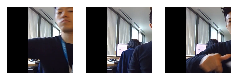

In [18]:
show_clip(random_resized_crop(t_clip))

6. Normalizing (and denormalizing to verify)

WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


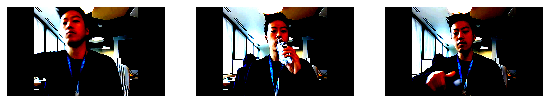

In [19]:
norm_t_clip = NormalizeVideo(mean=DEFAULT_MEAN, std=DEFAULT_STD)(t_clip)
show_clip(norm_t_clip)

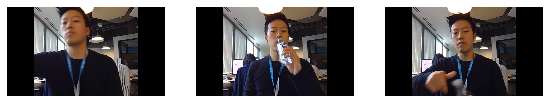

In [20]:
show_clip(denormalize(norm_t_clip, mean=DEFAULT_MEAN, std=DEFAULT_STD))

7. Horizontal flipping

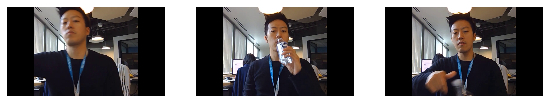

In [21]:
show_clip(RandomHorizontalFlipVideo(p=.5)(t_clip))